## 3b. Entrenamiento modelo Deep Learning

En este notebook implementaremos y compararemos dos modelos de Deep Learning:
1. **GRU**: Versión eficiente de LSTM con menos parámetros, más rápido, bien para dataset pequeños
2. **LSTM con Word2Vec**: Modelo estándar con embeddings pre-entrenados para capturar relacion semantica.

### 3.1 Setup

In [43]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Embedding, LSTM, GRU, Dense, Dropout, SpatialDropout1D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Usar keras_preprocessing (compatible con Keras 3)
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

from gensim.models import Word2Vec

import warnings
warnings.filterwarnings('ignore')


### 3.2 Carga de Datos Preprocesados

In [31]:
# Cargar datos preprocesados del Notebook 2
df = pd.read_pickle('Outputs/data/df_beauty_preprocessed_DL.pkl')

print(f"Dataset cargado: {len(df):,} reviews")
df.head()

Dataset cargado: 5,995 reviews


,review_processed_DL,label_sentiment
0,sculpting crean use this product and find that...,0
1,keep your money foe the price one expects more...,1
2,fell apart after year was good while lasted bu...,1
3,five stars works beautifully great for clients...,0
4,worst product recently purchased this product ...,1


In [34]:
# Preparar datos 
X = df['review_processed_DL'].values
y = df['label_sentiment'].values

print(f"Total: {len(X):,}")
print(pd.Series(y).value_counts())
print(f"\nEjemplo de texto preprocesado:")
print(X[0][:200])

Total: 5,995
1    3000
0    2995
dtype: int64

Ejemplo de texto preprocesado:
sculpting crean use this product and find that when run out notice the difference the tautness skin especially around mouth and neck


### 3.3 Tokenización

Parámetros usados:
- **vocab_size = 5000**: Balance entre cobertura y eficiencia para evitar overfitting
- **max_length = 100**: Longitud promedio de reviews
- **embedding_dim = 128**: Dimensión para Word2Vec

In [35]:
VOCAB_SIZE = 5000  
MAX_LENGTH = 100   
EMBEDDING_DIM = 128

# Tokenizer de Keras
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(X)

# Convertir textos a secuencias numéricas
sequences = tokenizer.texts_to_sequences(X)

# Padding: todas las secuencias con misma longitud
X_padded = pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post', truncating='post')

print(f"Vocabulario total: {len(tokenizer.word_index):,} palabras únicas")
print(f"Vocabulario usado: {VOCAB_SIZE:,} palabras")
print(f"Forma de X_padded: {X_padded.shape}")

Vocabulario total: 10,734 palabras únicas
Vocabulario usado: 5,000 palabras
Forma de X_padded: (5995, 100)


In [36]:
#Ejemplo:
print(f"Original: {X[0][:100]}...")
print(f"Secuencia: {sequences[0][:20]}...")
print(f"Padded: {X_padded[0][:20]}...")

Original: sculpting crean use this product and find that when run out notice the difference the tautness skin ...
Secuencia: [3264, 1, 22, 4, 10, 3, 199, 11, 36, 674, 29, 861, 2, 366, 2, 1, 43, 378, 188, 690]...
Padded: [3264    1   22    4   10    3  199   11   36  674   29  861    2  366
    2    1   43  378  188  690]...


### 3.4 División Train/Validation/Test

con stratify para asegurar balanceo de clases en las divisiones

- **Train**: 70% para entrenamiento
- **Validation**: 15% para ajuste de hiperparámetros y early stopping
- **Test**: 15% para evaluación final

In [40]:
# Train+Val (85%), Test (15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_padded, y, test_size=0.15, random_state=RANDOM_STATE, stratify=y
)

# Train (70%), Val (15%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=RANDOM_STATE, stratify=y_temp  
)


print(f"Train: {len(X_train):,}")
print(f"Validation: {len(X_val):,}")
print(f"Test: {len(X_test):,} ")

print(f"Train: Positivos={np.sum(y_train==0)}, Negativos={np.sum(y_train==1)}")
print(f"Positivos={np.sum(y_val==0)}, Negativos={np.sum(y_val==1)}")
print(f"Positivos={np.sum(y_test==0)}, Negativos={np.sum(y_test==1)}")

Train: 4,198
Validation: 897
Test: 900 
Train: Positivos=2097, Negativos=2101
Positivos=448, Negativos=449
Positivos=450, Negativos=450


### 3.5 Entrenamiento de Word2Vec

Word2Vec aprende representaciones semánticas, preentrenamos los embeddings antes de la LSTM

**Parámetros:**
- **vector_size=128**: Dimensión (coincide con EMBEDDING_DIM)
- **window=5**: Contexto de palabras vecinas
- **min_count=2**: Palabras que aparecen ≥2 veces
- **sg=1**: Skip-gram (mejor para datasets pequeños)

In [44]:
# Preparar datos para Word2Vec convirtiendo a lista de palabras
sentences = [text.split() for text in X] 

print(f"Ejemplo delista: {sentences[0][:15]}...")

# Entrenar Word2Vec
w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=EMBEDDING_DIM,  
    window=5,                    
    min_count=2,                
    workers=4,                   
    sg=1,                        
    epochs=10,                   
    seed=RANDOM_STATE
)

print(f"Vocabulario Word2Vec: {len(w2v_model.wv):,} palabras")


Ejemplo delista: ['sculpting', 'crean', 'use', 'this', 'product', 'and', 'find', 'that', 'when', 'run', 'out', 'notice', 'the', 'difference', 'the']...
Vocabulario Word2Vec: 5,544 palabras


In [45]:
# Guardar modelo Word2Vec
os.makedirs('Outputs/models', exist_ok=True)
w2v_model.save('Outputs/models/word2vec_beauty.model')
print("Modelo Word2Vec guardado en Outputs/models/word2vec_beauty.model")

Modelo Word2Vec guardado en Outputs/models/word2vec_beauty.model


In [ ]:
# Explorar similitudes 
# Palabras de ejemplo relacionadas con sentiment
test_words = ['bad', 'love', 'hate', 'price', 'product', 'recommend']

for word in test_words:
    if word in w2v_model.wv:
        similar = w2v_model.wv.most_similar(word, topn=5)
        print(f"\n'{word}' es similar a:")
        for sim_word, score in similar:
            print(f"  - {sim_word}: {score:.3f}")
    else:
        print(f"\n'{word}' no está en el vocabulario")


'bad' es similar a:
  - burnt: 0.709
  - news: 0.707
  - batch: 0.697
  - horrible: 0.693
  - nappy: 0.678

'love' es similar a:
  - amazing: 0.723
  - fantastic: 0.719
  - starter: 0.706
  - awesome: 0.701
  - loves: 0.693

'hate' es similar a:
  - besides: 0.878
  - advertise: 0.868
  - mesh: 0.866
  - detail: 0.865
  - technician: 0.863

'price' es similar a:
  - reasonable: 0.797
  - deal: 0.785
  - quantity: 0.752
  - value: 0.749
  - costume: 0.741

'product' es similar a:
  - satisfied: 0.704
  - item: 0.682
  - beyond: 0.678
  - expectations: 0.678
  - discount: 0.675

'recommend' es similar a:
  - anyone: 0.704
  - reccomend: 0.675
  - def: 0.657
  - proof: 0.655
  - yada: 0.651


#### Visualización 2D de embeddings con t-SNE

In [63]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

In [64]:
keys = ['love', 'waste', 'smell', 'hair', 'product']

In [65]:
embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in w2v_model.wv.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(w2v_model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [67]:
print(word_clusters)
print(f"Total de clusters: {len(embedding_clusters)}")

[['amazing', 'fantastic', 'starter', 'awesome', 'loves', 'incredible', 'fork', 'adorable', 'girls', 'mister'], ['wasted', 'bother', 'save', 'total', 'complete', 'mad', 'waist', 'hardearned', 'garbage', 'pretreatment'], ['odor', 'scent', 'cologne', 'smells', 'perfume', 'fragrance', 'vanilla', 'smelled', 'chemical', 'bourbon'], ['curly', 'tangles', 'bleached', 'wavy', 'shedding', 'tangled', 'frizzy', 'bleach', 'wave', 'bundles'], ['satisfied', 'item', 'beyond', 'expectations', 'discount', 'cologne', 'wow', 'early', 'jar', 'particular']]
Total de clusters: 5


In [68]:
#Preparar datos para t-SNE
# Aplanar embeddings para t-SNE
embedding_clusters_array = np.array(embedding_clusters)
n_words_per_cluster = embedding_clusters_array.shape[1]
embedding_dim = embedding_clusters_array.shape[2]

print(f"Palabras por cluster: {n_words_per_cluster}")
print(f"Dimensión de embeddings: {embedding_dim}")

Palabras por cluster: 10
Dimensión de embeddings: 128


In [69]:
# Reshape: (n_clusters, n_words, embedding_dim) -> (n_clusters * n_words, embedding_dim)
embeddings_flat = embedding_clusters_array.reshape(
    len(embedding_clusters) * n_words_per_cluster, 
    embedding_dim
)
print(f"Dimension para t-SNE: {embeddings_flat.shape}")

Dimension para t-SNE: (50, 128)


In [70]:
tsne_model_2d = TSNE(n_components=2,perplexity=15,init='pca',max_iter=3500,random_state=32,verbose=0)
embeddings_2d = tsne_model_2d.fit_transform(embeddings_flat)

# Reshape de vuelta: (n_clusters * n_words, 2) -> (n_clusters, n_words, 2)
embeddings_2d_clustered = embeddings_2d.reshape(len(embedding_clusters), n_words_per_cluster, 2)

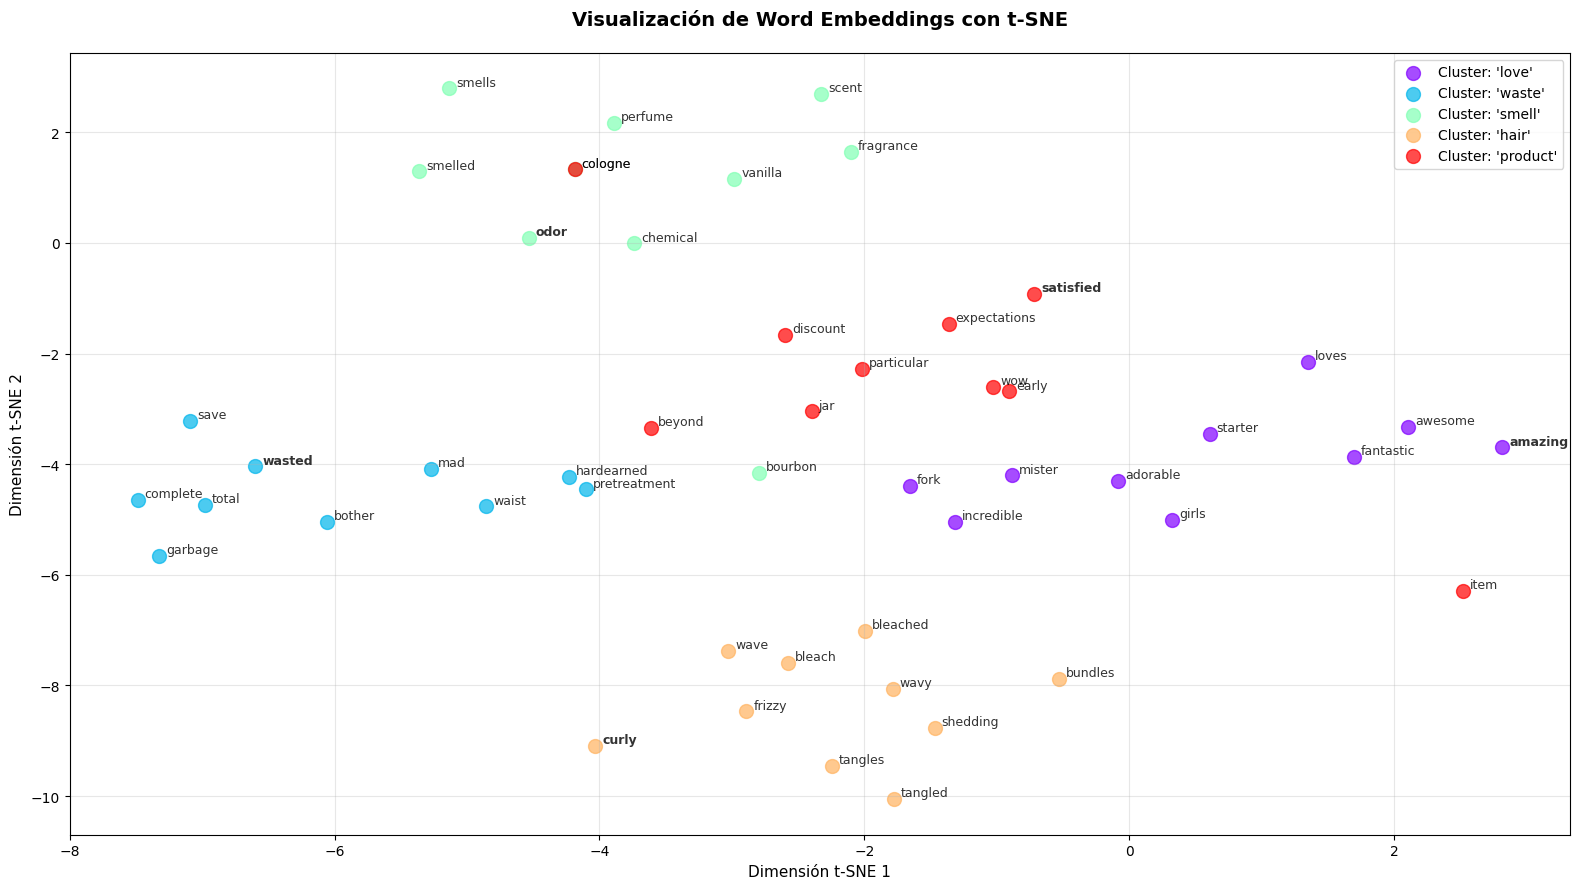

In [71]:
# Visualizar
fig, ax = plt.subplots(figsize=(16, 9))

# Colores para cada cluster
colors = plt.cm.rainbow(np.linspace(0, 1, len(embedding_clusters)))

# Plotear cada cluster
for idx, (word_cluster, embedding_cluster, color) in enumerate(
    zip(word_clusters, embeddings_2d_clustered, colors)
):
    # Extraer coordenadas x, y
    x_coords = embedding_cluster[:, 0]
    y_coords = embedding_cluster[:, 1]
    
    # Plotear puntos
    ax.scatter(
        x_coords, 
        y_coords, 
        c=[color], 
        alpha=0.7, 
        s=100,
        label=f"Cluster: '{keys[idx]}'"
    )
    
    # Agregar etiquetas de texto
    for i, word in enumerate(word_cluster):
        ax.annotate(
            word,
            xy=(x_coords[i], y_coords[i]),
            xytext=(5, 2),
            textcoords='offset points',
            fontsize=9,
            alpha=0.8,
            weight='bold' if i == 0 else 'normal'  # Palabra semilla en negrita
        )

ax.set_title('Visualización de Word Embeddings con t-SNE', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Dimensión t-SNE 1', fontsize=11)
ax.set_ylabel('Dimensión t-SNE 2', fontsize=11)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Clusters identificados:

- MORADO `love`: fuertes predictores de sentimiento positivo
- AZUL `waste`: fuerte predictor de sentiemitno negativo (Desperdicio)
- VERDE `smell`, NARANJA `hair`, ROJO `product`: ambiguos, neutros o necesitan contexto

En base a esto, considerar usar bigramas/trigramas para el modelo para palabras ambiguas.

#### Creamos matriz de embeddings

In [72]:
# Inicializar con ceros
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

# Llenar matriz con vectores de Word2Vec
words_found = 0
for word, idx in tokenizer.word_index.items():
    if idx < VOCAB_SIZE:  # Solo palabras en nuestro vocabulario
        if word in w2v_model.wv:
            embedding_matrix[idx] = w2v_model.wv[word]
            words_found += 1

coverage = (words_found / VOCAB_SIZE) * 100
print(f"Matriz de embeddings creada: {embedding_matrix.shape}")
print(f"Palabras encontradas en Word2Vec: {words_found:,}/{VOCAB_SIZE:,} ({coverage:.1f}%)")
print(f"Palabras sin embedding (inicializadas a cero): {VOCAB_SIZE - words_found:,}")

Matriz de embeddings creada: (5000, 128)
Palabras encontradas en Word2Vec: 4,998/5,000 (100.0%)
Palabras sin embedding (inicializadas a cero): 2


### 3.6 Modelo 1: GRU

**Parámetros:**
- **GRU units=64**: Balance entre capacidad y overfitting para ~5K samples
- **Dropout=0.5**: Regularización fuerte para evitar overfitting
- **trainable=False**: Mantener embeddings Word2Vec fijos

In [ ]:
def build_gru_model(embedding_matrix):
    model = Sequential([
            Embedding(VOCAB_SIZE, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_LENGTH,trainable=False),
        GRU(64, dropout=0.2, recurrent_dropout=0.2),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
    )
    
    return model

gru_model = build_gru_model(embedding_matrix)

print("Modelo GRU creado con embeddings de Word2Vec")

Modelo GRU creado con embeddings de Word2Vec


In [49]:
print(gru_model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 640,000 (2.44 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 640,000 (2.44 MB)

None


In [50]:
# Callbacks para GRU
gru_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'outputs/models/gru_best.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
]

In [51]:
# Entrenar GRU
BATCH_SIZE = 32
EPOCHS = 20

gru_history = gru_model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=gru_callbacks,
    verbose=1
)

print("Entrenamiento GRU completado")

Epoch 1/20
131/132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4733 - loss: 0.6942 - precision_3: 0.4297 - recall_3: 0.1971
Epoch 1: val_accuracy improved from None to 0.51171, saving model to outputs/models/gru_best.h5


132/132 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.4909 - loss: 0.6937 - precision_3: 0.4888 - recall_3: 0.3746 - val_accuracy: 0.5117 - val_loss: 0.6920 - val_precision_3: 0.5063 - val_recall_3: 0.9822
Epoch 2/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5096 - loss: 0.6916 - precision_3: 0.5073 - recall_3: 0.9013
Epoch 2: val_accuracy did not improve from 0.51171
132/132 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.5033 - loss: 0.6914 - precision_3: 0.5026 - recall_3: 0.7477 - val_accuracy: 0.4994 - val_loss: 0.6916 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 3/20
131/132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4982 - loss: 0.6909 - precision_3: 0.4960 - recall_3: 0.5917
Epoch 3: val_accuracy did not improve from 0.51171
132/132 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.4981 - loss: 0.6916 - precision_3: 0.4988 - recall_3: 0.5750 - val_accuracy: 0.5072 - val_loss: 0.6917 - val_precision_3: 0.5040 - val_recall_3: 0.9755
Epoch 4/20

### 3.7 Modelo 2: LSTM con Word2Vec

**Ventajas de LSTM:**
- **Más parámetros**: Mayor capacidad de aprendizaje
- **Mejor para secuencias largas**: Captura dependencias complejas
- **Maneja negaciones**: Mejor contexto para sentiment analysis

In [52]:
# Construir modelo LSTM con Word2Vec embeddings
def build_lstm_model(embedding_matrix):
    model = Sequential([
        Embedding(VOCAB_SIZE, EMBEDDING_DIM,weights=[embedding_matrix],input_length=MAX_LENGTH,trainable=False),
        LSTM(64, dropout=0.2, recurrent_dropout=0.2),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
    )
    
    return model

lstm_model = build_lstm_model(embedding_matrix)

print("Modelo LSTM creado con embeddings de Word2Vec")

Modelo LSTM creado con embeddings de Word2Vec


In [53]:
print(lstm_model.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 640,000 (2.44 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 640,000 (2.44 MB)

None


In [55]:
# Callbacks para LSTM
lstm_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'outputs/models/lstm_best.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1)
]

In [56]:
# Entrenar LSTM
lstm_history = lstm_model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=lstm_callbacks,
    verbose=1
)

print("Entrenamiento LSTM completado")

Epoch 1/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4841 - loss: 0.6935 - precision_4: 0.4752 - recall_4: 0.4028
Epoch 1: val_accuracy improved from None to 0.50613, saving model to outputs/models/lstm_best.h5


132/132 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.4900 - loss: 0.6928 - precision_4: 0.4883 - recall_4: 0.3974 - val_accuracy: 0.5061 - val_loss: 0.6918 - val_precision_4: 0.5035 - val_recall_4: 0.9666
Epoch 2/20
131/132 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5059 - loss: 0.6923 - precision_4: 0.4986 - recall_4: 0.6199
Epoch 2: val_accuracy improved from 0.50613 to 0.50948, saving model to outputs/models/lstm_best.h5


132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.5138 - loss: 0.6915 - precision_4: 0.5109 - recall_4: 0.6687 - val_accuracy: 0.5095 - val_loss: 0.6915 - val_precision_4: 0.5052 - val_recall_4: 0.9755
Epoch 3/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5091 - loss: 0.6897 - precision_4: 0.5076 - recall_4: 0.7669
Epoch 3: val_accuracy improved from 0.50948 to 0.51171, saving model to outputs/models/lstm_best.h5


132/132 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.5040 - loss: 0.6894 - precision_4: 0.5036 - recall_4: 0.6378 - val_accuracy: 0.5117 - val_loss: 0.6919 - val_precision_4: 0.5064 - val_recall_4: 0.9755
Epoch 4/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5051 - loss: 0.6883 - precision_4: 0.4959 - recall_4: 0.5440
Epoch 4: val_accuracy did not improve from 0.51171
132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.5095 - loss: 0.6891 - precision_4: 0.5105 - recall_4: 0.4879 - val_accuracy: 0.5095 - val_loss: 0.6925 - val_precision_4: 0.5052 - val_recall_4: 0.9777
Epoch 5/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5221 - loss: 0.6872 - precision_4: 0.5176 - recall_4: 0.9380
Epoch 5: val_accuracy improved from 0.51171 to 0.52731, saving model to outputs/models/lstm_best.h5


132/132 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.5126 - loss: 0.6862 - precision_4: 0.5091 - recall_4: 0.7292 - val_accuracy: 0.5273 - val_loss: 0.6935 - val_precision_4: 0.5152 - val_recall_4: 0.9443
Epoch 6/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6179 - loss: 0.6319 - precision_4: 0.5701 - recall_4: 0.9044
Epoch 6: val_accuracy improved from 0.52731 to 0.63322, saving model to outputs/models/lstm_best.h5


132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.6255 - loss: 0.6229 - precision_4: 0.5773 - recall_4: 0.9405 - val_accuracy: 0.6332 - val_loss: 0.6035 - val_precision_4: 0.5783 - val_recall_4: 0.9866
Epoch 7/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5971 - loss: 0.6423 - precision_4: 0.5602 - recall_4: 0.9617
Epoch 7: val_accuracy did not improve from 0.63322
132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.5586 - loss: 0.6596 - precision_4: 0.5330 - recall_4: 0.9524 - val_accuracy: 0.5373 - val_loss: 0.6730 - val_precision_4: 0.5201 - val_recall_4: 0.9800
Epoch 8/20
131/132 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5501 - loss: 0.6624 - precision_4: 0.5274 - recall_4: 0.9426
Epoch 8: val_accuracy did not improve from 0.63322
132/132 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.5696 - loss: 0.6503 - precision_4: 0.5398 - recall_4: 0.9495 - val_accuracy: 0.5909 - val_loss: 0.6353 - val_precision_4: 0.5516 - val_recall_4: 0.9755
Epoch 9/20
132/132

### 3.8 Evaluación de Modelos en Test

In [58]:
# Evaluación GRU
# Predicciones
y_pred_gru_proba = gru_model.predict(X_test)
y_pred_gru = (y_pred_gru_proba > 0.5).astype(int).flatten()

# Métricas
gru_accuracy = accuracy_score(y_test, y_pred_gru)
gru_precision = precision_score(y_test, y_pred_gru)
gru_recall = recall_score(y_test, y_pred_gru)
gru_f1 = f1_score(y_test, y_pred_gru)
gru_auc = roc_auc_score(y_test, y_pred_gru_proba)

print(f"\nAccuracy:  {gru_accuracy:.4f}")
print(f"Precision: {gru_precision:.4f}")
print(f"Recall:    {gru_recall:.4f}")
print(f"F1-Score:  {gru_f1:.4f}")
print(f"ROC-AUC:   {gru_auc:.4f}")

print("\nClassification Report GRU:")
print(classification_report(y_test, y_pred_gru, target_names=['Positive', 'Negative']))

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Accuracy:  0.5000
Precision: 0.0000
Recall:    0.0000
F1-Score:  0.0000
ROC-AUC:   0.5093

Classification Report GRU:
              precision    recall  f1-score   support

    Positive       0.50      1.00      0.67       450
    Negative       0.00      0.00      0.00       450

    accuracy                           0.50       900
   macro avg       0.25      0.50      0.33       900
weighted avg       0.25      0.50      0.33       900



In [59]:
# Evaluación LSTM
# Predicciones
y_pred_lstm_proba = lstm_model.predict(X_test)
y_pred_lstm = (y_pred_lstm_proba > 0.5).astype(int).flatten()

# Métricas
lstm_accuracy = accuracy_score(y_test, y_pred_lstm)
lstm_precision = precision_score(y_test, y_pred_lstm)
lstm_recall = recall_score(y_test, y_pred_lstm)
lstm_f1 = f1_score(y_test, y_pred_lstm)
lstm_auc = roc_auc_score(y_test, y_pred_lstm_proba)

print(f"\nAccuracy:  {lstm_accuracy:.4f}")
print(f"Precision: {lstm_precision:.4f}")
print(f"Recall:    {lstm_recall:.4f}")
print(f"F1-Score:  {lstm_f1:.4f}")
print(f"ROC-AUC:   {lstm_auc:.4f}")

print("\nClassification Report LSTM:")
print(classification_report(y_test, y_pred_lstm, target_names=['Positive', 'Negative']))

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step

Accuracy:  0.6278
Precision: 0.5742
Recall:    0.9889
F1-Score:  0.7265
ROC-AUC:   0.6346

Classification Report LSTM:
              precision    recall  f1-score   support

    Positive       0.96      0.27      0.42       450
    Negative       0.57      0.99      0.73       450

    accuracy                           0.63       900
   macro avg       0.77      0.63      0.57       900
weighted avg       0.77      0.63      0.57       900



### 3.9 Comparación Final: GRU vs LSTM

In [61]:
# Tabla comparativa
results_dl = pd.DataFrame({
    'Model': ['GRU', 'LSTM + Word2Vec'],
    'Accuracy': [gru_accuracy, lstm_accuracy],
    'Precision': [gru_precision, lstm_precision],
    'Recall': [gru_recall, lstm_recall],
    'F1-Score': [gru_f1, lstm_f1],
    'ROC-AUC': [gru_auc, lstm_auc]
})

print("COMPARACIÓN GRU vs LSTM + Word2Vec")
print(results_dl.to_string(index=False))

# Identificar mejor modelo
best_model_idx = results_dl['F1-Score'].idxmax()
best_model_name = results_dl.loc[best_model_idx, 'Model']
best_f1 = results_dl.loc[best_model_idx, 'F1-Score']

print(f"\nMejor modelo: {best_model_name} (F1-Score: {best_f1:.4f})")

# Guardar resultados
results_dl.to_csv('outputs/results_deep_learning.csv', index=False)
print("Resultados guardados en outputs/results_deep_learning.csv")

COMPARACIÓN GRU vs LSTM + Word2Vec
          Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
            GRU  0.500000   0.000000 0.000000  0.000000 0.509277
LSTM + Word2Vec  0.627778   0.574194 0.988889  0.726531 0.634600

Mejor modelo: LSTM + Word2Vec (F1-Score: 0.7265)
Resultados guardados en outputs/results_deep_learning.csv


### 3.10 Conclusiones

#### Sobre Word2Vec:
- **Ventajas**: Captura relaciones semánticas, palabras similares tienen vectores cercanos
- **Limitaciones**: Requiere corpus grande, palabras OOV se inicializan a cero

#### Comparación GRU vs LSTM:
- **GRU**: Más eficiente, menos parámetros, entrena más rápido, menos overfitting
- **LSTM**: Más parámetros, mejor para secuencias largas, estándar de la industria

#### Recomendaciones:
1. **Para datasets pequeños-medianos (~6K)**: GRU suele ser mejor opción
2. **Para reviews largas**: LSTM captura mejor las dependencias

In [62]:
# Guardar el mejor modelo según F1-Score
if best_model_name == 'GRU':
    gru_model.save('Outputs/models/best_dl_model.h5')
    print(f"✓ Mejor modelo (GRU) guardado en Outputs/models/best_dl_model.h5")
else:
    lstm_model.save('Outputs/models/best_dl_model.h5')
    print(f"✓ Mejor modelo (LSTM) guardado en Outputs/models/best_dl_model.h5")

# Guardar tokenizer
with open('Outputs/models/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
print("✓ Tokenizer guardado en Outputs/models/tokenizer.pkl")

# Guardar embedding matrix
np.save('Outputs/models/embedding_matrix.npy', embedding_matrix)
print("✓ Embedding matrix guardada en Outputs/models/embedding_matrix.npy")

print(f"Mejor modelo: {best_model_name} (F1-Score: {best_f1:.4f})")


✓ Mejor modelo (LSTM) guardado en Outputs/models/best_dl_model.h5
✓ Tokenizer guardado en Outputs/models/tokenizer.pkl
✓ Embedding matrix guardada en Outputs/models/embedding_matrix.npy
Mejor modelo: LSTM + Word2Vec (F1-Score: 0.7265)
